# Part 2) Coupling IGM and landscape evolution models

In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter
from landlab import RasterModelGrid
from landlab.components import FlowAccumulator

## Why don't we have ice flow components in Landlab?
Well, nobody has written them yet. Or at least, nobody has written them in a way where they run in a reasonable amount of time, don't crash when given reasonable initial conditions, and use Landlab's native grid types and numerical operators. But, we also don't need to reinvent the wheel. Just in our 2025 clinics alone, we have two different examples of excellent open-source ice sheet models, [icepack](https://icepack.github.io/) and [IGM](https://github.com/jouvetg/igm/wiki). There are plenty of others, especially if your goal is to run realistic simulations of modern-day systems using higher-order approximations of the full Stokes equations.

## Does this mean I can't do glacial geomorphology in Landlab?
#### No!
It just means that you're going to have to write some extra code yourself. While there are lots of components in Landlab for surface processes, there are very few that work on, in, or under ice masses. But, we still gain a huge advantage by using the Landlab grid architecture and utilities. And, it makes it much easier to couple glacial and periglacial processes.

## What's the best way to start coupling ice flow models and Landlab components?
In this notebook, we're going to walk through a one-way coupling between an IGM simulation and landscape evolution components. It is *one-way* because we will use the ice thickness and sliding velocity output from IGM to drive sediment erosion and transport, but we're not going to feed the resulting change in topography back into IGM.

## What about two-way coupling?
Try it yourself! Maybe not in the two hours we have for this clinic, since things might break. A good rule of thumb is that the headaches created by coupling nonlinear PDEs are themselves nonlinear. But, to do so, you could run IGM for a reasonable amount of time, whatever that means, update the bed topography through glacial erosion and deformation, remake the input.nc file with new input data, and then restart your run at the next time step.

# A geomorphically "hot" run of Mendenhall Glacier, AK
To make this example cool, we have made a few updates to the ```params.json``` file. Check them out now:

In [2]:
%cat ./examples/mendenhall/params.json

{
  "modules_preproc": ["oggm_shop"],
  "modules_process": ["clim_oggm",
                      "smb_oggm",
                      "iceflow",
                      "time",
                      "thk"
                      ],
  "modules_postproc": ["write_ncdf",
                       "plot2d",
                       "print_info",
                       "print_comp"],
  "wncd_vars_to_save": [
		"topg", "usurf", "thk", "smb", 
		"velbar_mag", "velsurf_mag", 
		"uvelsurf", "vvelsurf", "wvelsurf", 
		"uvelbase", "vvelbase"
			],
  "clim_oggm_clim_trend_array": [
                        ["time", "delta_temp", "prec_scal"],
                        [ 2000,           0.0,         1.0],
                        [ 2020,           0.0,         1.0]
                                 ],
  "oggm_RGI_ID": "RGI60-01.00709",
  "time_start": 2000.0,
  "time_end": 2100.0,
  "time_save": 5,
  "plt2d_live": true,
  "iflo_init_slidingco": 0.000001,
  "iflo_init_arrhenius": 75,
  "iflo_exp_weertman": 3,
  "oggm_

Notice that we've added a new parameter, ```wncd_vars_to_save```: this allows us to specify the fields we'd like to write out. Specifically for this example, we want the components of sliding velocity, ```uvelbase``` and ```vvelbase```. Also, we have changed the initial value of the sliding coefficient, ```iflo_init_slidingco```, to be 10$^{-6}$ MPa m$^{-1/3}$ a$^{-1/3}$, and the initial value of the ice fluidity parameter, ```iflo_init_arrhenius```, to be 75 MPa$^{-3}$ a$^{-1}$. Note that it would be much better$^*$ to get one or both of these values from the ```optimize``` module, which would allow us to match observed surface velocity or ice thickness using an inverse method. Finally, we're going to drive the glacier with a surface mass balance parameterization from 2000-2020, using OGGM, but run it out until 2100. This illustrates a fairly conservative retreat scenario, but one that is hopefully informative.

<sub>$^*$better defined in this case as "higher fidelity to what we think we know about the physical glacier our numerical model purportedly represents." This is distinct from other definitions of better, such as "runs in a reasonable amount of time given 8 GB of memory on a JupyterHub instance" or "provides an answer without asking the modeler to be deeply introspective about the amount of uncertainty they are willing to accept in their models and measurements."</sub>

**With all that said, go ahead and run the Mendenhall retreat scenario:**
```
cd examples/mendenhall
```
```
igm_run --param_file params.json
```

# Visualize results

In [3]:
# Load output
ds = xr.open_dataset('./examples/mendenhall/output.nc')
print('Dataset shape:', ds.topg.shape)
print(ds.data_vars)

Dataset shape: (21, 244, 217)
Data variables:
    topg         (time, y, x) float32 4MB ...
    usurf        (time, y, x) float32 4MB ...
    thk          (time, y, x) float32 4MB ...
    smb          (time, y, x) float32 4MB ...
    velbar_mag   (time, y, x) float32 4MB ...
    velsurf_mag  (time, y, x) float32 4MB ...
    uvelsurf     (time, y, x) float32 4MB ...
    vvelsurf     (time, y, x) float32 4MB ...
    uvelbase     (time, y, x) float32 4MB ...
    vvelbase     (time, y, x) float32 4MB ...


In [4]:
# Generate the Landlab grid
grid = RasterModelGrid((ds.y.shape[0], ds.x.shape[0]))

In [5]:
# Flip variables to orient the glacier north-south
topg = np.flip(ds.topg.values, axis = 1)
usurf = np.flip(ds.usurf.values, axis = 1)
thk = np.flip(ds.thk.values, axis = 1)
ubar = np.flip(ds.velbar_mag.values, axis = 1)
us = np.flip(ds.velsurf_mag.values, axis = 1)
smb = np.flip(ds.smb.values, axis = 1)

In [6]:
# Animation of ice thickness over the course of the run

In [7]:
# Animation of sliding velocity over the course of the run

# What is a landscape evolution model's view of a glacier?

There are many interesting and deep interactions to explore between glaciers and the landscapes they inhabit and help form. For now, however, we're going to take a reductive view of the system. To the surrounding landscape, a glacier is a source of sediment and water. To give you a starting point into coupling IGM and Landlab components, we'll show a simple way to produce those output fields from what IGM gives us.

First, let's calculate an erosion rate for our glacier. We'll use the following semi-empirical relationship from Ugelvig and Egholm (2016)<sup>1</sup>:
$$
E = K\; N^3\; |u_b|\; \nabla s^2,
$$
where $E$ is the erosion rate from quarrying, $K$ is an erodibility coefficient, $N$ is the *effective pressure* (ice overburden pressure - water pressure), $u_b$ is the sliding velocity, and $s$ is the surface elevation. 

1. Ugelvig, S. V., Egholm, D. L., & Iverson, N. R. (2016). Glacial landscape evolution by subglacial quarrying: A multiscale computational approach. Journal of Geophysical Research: Earth Surface, 121(11), 2042-2068.

In [8]:
K = 7.5e-6

Pi = 917 * 9.81 * thk
Pw = 0.8 * Pi # or, insert results from a subglacial hydrology model here. if you dare.
effective_pressure = Pi - Pw

ub_not_flipped = np.sqrt(ds.uvelbase.values**2 + ds.vvelbase.values**2)
sliding_velocity = np.flip(ub_not_flipped, axis = 1)

surface_smooth = gaussian_filter(usurf, sigma = 5, mode = 'reflect')
surface_grad_at_links = grid.calc_grad_at_link(surface_smooth)
surface_slope = grid.map_mean_of_links_to_node(surface_grad_at_links)
surface_slope = np.reshape(surface_slope, grid.shape)

erosion_rate = K * effective_pressure**3 * sliding_velocity * surface_slope**2

In [9]:
# Cumulative erosion over the course of the simulation

Second, we'll just do some simple flow routing to get the water produced by the glacier moving downstream. There are really two components to worry about here:
$$
Q = Q_s + Q_b,
$$
where $Q$ is the total water flux, $Q_s$ is the surface melt that makes it to the bed, and $Q_b$ is the basal melt. For now, let's assume that all of the surface meltwater is routed to the bed. (I encourage you to modify the following code to relax that assumption!) The surface melt flux is basically the surface mass balance returned by IGM, and we can model the basal melt flux with:
$$
Q_b = \frac{u_b \tau_b + G}{\rho L},
$$
where $\tau_b$ is the basal shear stress, $G$ is the geothermal heat flux, $\rho$ is the ice density, and $L$ is the latent heat of fusion for ice.

In [10]:
shear_stress = 1e-6 / sliding_velocity**(-3)
frictional_heat = shear_stress * sliding_velocity
geothermal_heat = 0.06 # reasonable value for southeast Alaska

rho = 917
L = 3.34e5
sec_per_a = 31556926

basal_melt = (frictional_heat + geothermal_heat) / (rho * L) * sec_per_a

smb_water = smb * rho / 1000
surface_melt = -1 * np.minimum(smb_water, np.zeros_like(smb))

total_melt = basal_melt + surface_melt
total_melt = np.where(thk > 0, total_melt, np.nan)

In [11]:
# Animation of total melt rate

Let's finish by actually routing the water into our landscape. Note that this is not necessarily how a subglacial hydrology model would accomplish this, but it's also not necessarily any worse. Certainly, if we are concerned with simply getting material from beneath the glacier out into our landscape, this is a perfectly fine way to do so. What we're going to do is assume that the hydraulic potential is the sum of potential from ice overburden and the bedrock elevation.

In [12]:
potential = 917 * 9.81 * thk + 1000 * 9.81 * topg
surface = np.where(thk > 0, potential, np.nan)

surface = surface.astype(float)
grid.at_node['water__unit_flux_in'] = total_melt[0].astype(float)

FA = FlowAccumulator(
    grid = grid,
    surface = surface[0],
    flow_director = 'D8'
)
FA.run_one_step()

In [13]:
# Plot evolving "drainage systems" over time

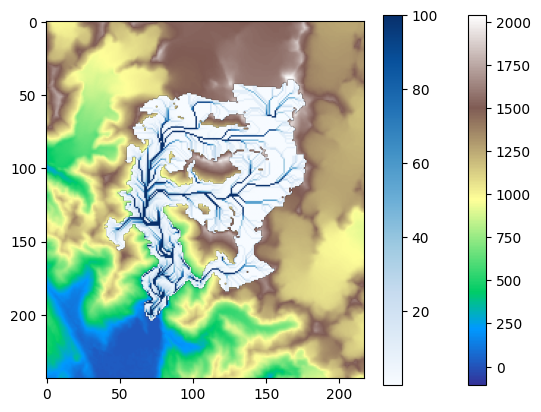

In [14]:
im = plt.imshow(topg[0], cmap = 'terrain')
plt.colorbar(im)

field = np.reshape(grid.at_node['surface_water__discharge'], grid.shape)
mask = np.where(thk[0] > 0, field, np.nan)
im2 = plt.imshow(mask, cmap = 'Blues', vmax = 100)
plt.colorbar(im2)
plt.show()